In [1]:
# Import necessary libraries
import gym
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
# Create a Blackjack environment with a fixed deck and no splitting or doubling down
env = gym.make('Blackjack-v1', natural=False, sab=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
# Define Q-learning parameters
num_episodes = 50000  # Number of episodes to train
learning_rate = 0.1  # Learning rate (alpha)
discount_factor = 0.99  # Discount factor (gamma)
exploration_rate = 1.0  # Initial exploration rate (epsilon)
exploration_decay = 0.99995  # Exploration decay rate
min_exploration_rate = 0.01  # Minimum exploration rate

In [4]:
# Initialize the Q-table
action_space_size = env.action_space.n  # Two possible actions: Stick (0) or Hit (1)
q_table = np.zeros((32, 11, 2, action_space_size))  # Q-table size: (Player's current sum, Dealer's showing card, Usable Ace, Action)

In [5]:
# Initialize lists for plotting
episode_rewards = []
average_rewards = []

In [6]:
# Function to choose an action based on the exploration-exploitation trade-off
def choose_action(state):
    """
    Choose an action based on the exploration-exploitation trade-off.

    Args:
        state: A tuple containing the player's current sum, dealer's showing card, and usable ace.

    Returns:
        An action (0 or 1) based on the exploration rate.
    """
    player_sum, dealer_card, usable_ace = state
    if random.uniform(0, 1) < exploration_rate:
        # Explore: Random action
        return env.action_space.sample()
    else:
        # Exploit: Choose the action with the highest Q-value
        return np.argmax(q_table[player_sum, dealer_card, int(usable_ace)])

In [7]:
# Evaluate the trained agent
def evaluate_agent(env, q_table, num_episodes=1000):
    """
    Evaluate the trained agent by playing a fixed number of episodes.

    Args:
        env: The Blackjack environment.
        q_table: The trained Q-table.
        num_episodes: The number of episodes to play.

    Returns:
        The number of wins, losses, and draws.
    """
    wins = 0
    losses = 0
    draws = 0

    for _ in range(num_episodes):
        state = env.reset()
        done = False

        while not done:
            # Unpack state tuple
            player_sum, dealer_card, usable_ace = state

            # Choose the best action using the Q-table
            action = np.argmax(q_table[player_sum, dealer_card, int(usable_ace)])

            # Take the chosen action and observe the result
            next_state, reward, done, _ = env.step(action)
            state = next_state

        # Record the result
        if reward > 0:
            wins += 1
        elif reward < 0:
            losses += 1
        else:
            draws += 1

    print(f"Evaluation over {num_episodes} episodes:")
    print(f"Wins: {wins}, Losses: {losses}, Draws: {draws}")

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 5000/50000 completed.
Episode 10000/50000 completed.
Episode 15000/50000 completed.
Episode 20000/50000 completed.
Episode 25000/50000 completed.
Episode 30000/50000 completed.
Episode 35000/50000 completed.
Episode 40000/50000 completed.
Episode 45000/50000 completed.
Episode 50000/50000 completed.


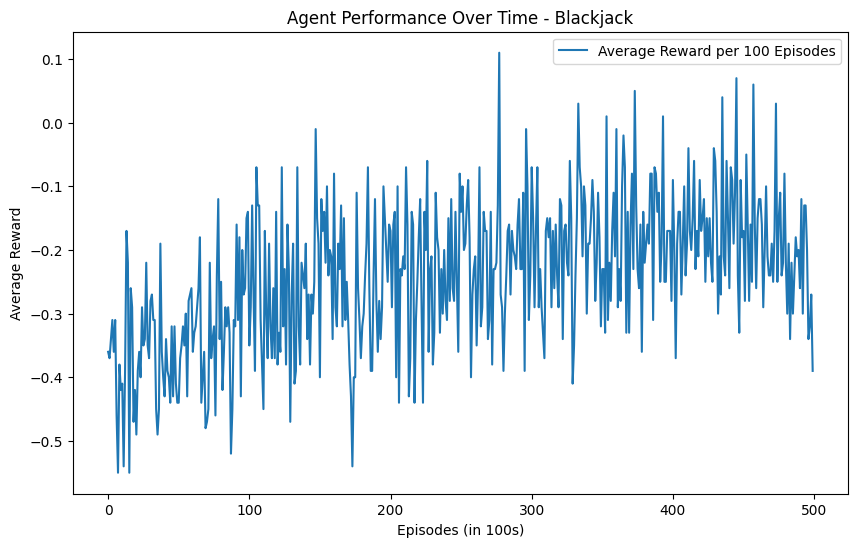

In [8]:
# Training the agent
for episode in range(num_episodes):
    # Reset the environment and get the initial state
    state = env.reset()
    done = False
    total_reward = 0  # Initialize total reward for the current episode

    while not done:
        # Unpack state tuple
        player_sum, dealer_card, usable_ace = state

        # Choose action using epsilon-greedy policy
        action = choose_action(state)

        # Take the chosen action and observe the result
        next_state, reward, done, _ = env.step(action)

        # Unpack next_state tuple
        next_player_sum, next_dealer_card, next_usable_ace = next_state

        # Update Q-value using the Q-learning formula
        best_next_action = np.argmax(q_table[next_player_sum, next_dealer_card, int(next_usable_ace)])
        q_table[player_sum, dealer_card, int(usable_ace), action] += learning_rate * (
            reward + discount_factor * q_table[next_player_sum, next_dealer_card, int(next_usable_ace), best_next_action]
            - q_table[player_sum, dealer_card, int(usable_ace), action]
        )

        # Update state and reward
        state = next_state
        total_reward += reward

    # Append the total reward of this episode for plotting
    episode_rewards.append(total_reward)

    # Calculate average reward for last 100 episodes
    if (episode + 1) % 100 == 0:
        average_rewards.append(np.mean(episode_rewards[-100:]))

    # Decay the exploration rate
    exploration_rate = max(min_exploration_rate, exploration_rate * exploration_decay)

    # Print the progress
    if (episode + 1) % 5000 == 0:
        print(f"Episode {episode + 1}/{num_episodes} completed.")

# Plotting the average rewards
plt.figure(figsize=(10, 6))
plt.plot(average_rewards, label='Average Reward per 100 Episodes')
plt.xlabel('Episodes (in 100s)')
plt.ylabel('Average Reward')
plt.title('Agent Performance Over Time - Blackjack')
plt.legend()
plt.show()

In [9]:
# Run the evaluation
evaluate_agent(env, q_table)

Evaluation over 1000 episodes:
Wins: 396, Losses: 531, Draws: 73
